<a href="https://colab.research.google.com/github/Riverag0011/ADS-504-02-Machine-Learning-Deep-Learning-For-Data-Science/blob/main/Assignment_5_1_Exercises_Code_GR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5.1 Exercises

Name: Gabi Rivera\
Date: 28Jul2024\
Course: ADS504-02

In [ ]:
# Library

#!pip uninstall scikit-learn -y
#!pip install scikit-learn
import pandas as pd
import numpy as np
import os
import tarfile
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from time import time
import sklearn
from skimage import io
from skimage.color import rgb2gray
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib.image import imread
import glob
import warnings

warnings.filterwarnings('ignore')

## Cat Faces:

Get the cat-faces dataset from: https://github.com/fferlito/Cat-faces-dataset \
Load all the images in the first zip file. Use scikit-image (https://scikit-image.org/) to load the
images and convert them to grayscale (rgb2gray).\
Adapt the code from the following website to work with the cat faces:
https://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

In [ ]:
# Create output folder
os.makedirs('/content/output_folder', exist_ok=True)

# Extract the tar file
!tar -xvf /content/dataset-part1.tar.gz -C /content/output_folder

# Verify the extraction
!ls -lh /content/output_folder

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_1411.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_2397.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_2223.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_2892.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_7455.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_1741.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_9189.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_7802.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_5493.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
dataset-part1/cat_6994.png
tar: Ignoring unknown extended header keyword 'SCHILY.fflag

In [ ]:
# Define the path
path = "/content/output_folder/dataset-part1"

print("\nRetrieving cat images from:")
print(path)

# Get a list of all directories in the path
folders = glob.glob(path)
cat_col = []
i = 0

# Loop through each folder
for folder in folders:
    # Get a list of all .png files in the folder
    for f in glob.glob(folder + '/*.png'):
        i = i + 1
        cat_col.append(f)

print("\nCat images found: " + str(i))


Retrieving cat images from:
/content/output_folder/dataset-part1

Cat images found: 10000


# Grayscale image

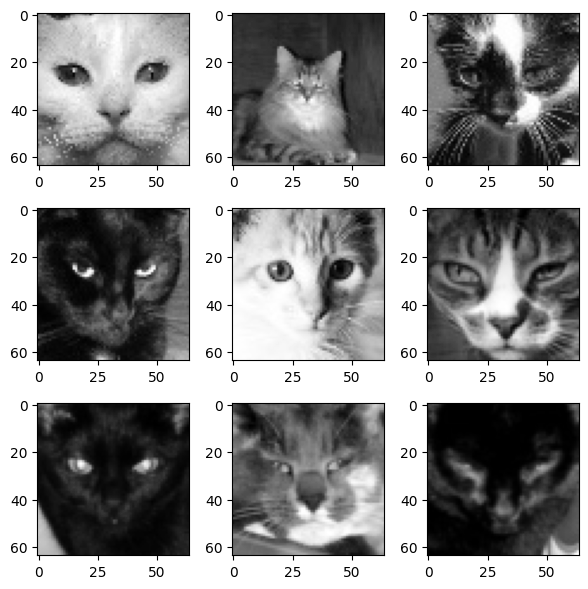

In [ ]:
import cv2

# Create a grid of subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
axes = ax.flatten()

# Loop through each subplot and image
for i in range(9):
    path = cat_col[i]
    img = cv2.imread(path)
    gray_img = rgb2gray(img)

    # Display the image
    axes[i].imshow(gray_img, cmap='gray')
    axes[i].axis('on')

plt.tight_layout()
plt.show()

In [ ]:
# Set the array in gray
cat_col_num = []

for i in range(0,10000):
  cat_col_num.append(rgb2gray(imread(cat_col[i])))

cat_col_num = np.array(cat_col_num)

# Reshape the array
cat_resh = cat_col_num.reshape(cat_col_num.shape[0],
                               cat_col_num.shape[1] * cat_col_num.shape[1])

# Center the data
cat_centered = cat_resh - cat_resh.mean(axis=0)

# Center the Data (Row-wise Mean Subtraction):
cat_centered -= cat_centered.mean(axis=1).reshape(cat_col_num.shape[0], -1)

print("Original shape:", cat_col_num.shape)
print("Reshaped shape:", cat_resh.shape)
print("Centered shape:", cat_centered.shape)

Original shape: (10000, 64, 64)
Reshaped shape: (10000, 4096)
Centered shape: (10000, 4096)


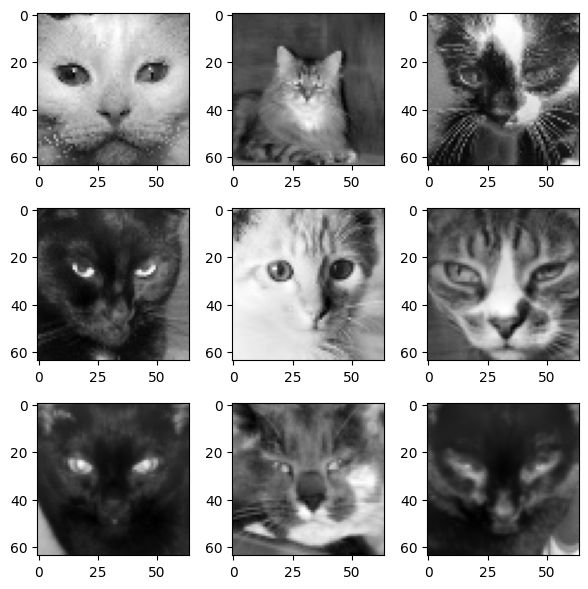

In [ ]:
# Create a grid of subplots
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
axes = ax.flatten()

for i in range(9):
    # Reshape each image back to 2D
    height, width = cat_col_num.shape[1], cat_col_num.shape[2]
    image_reshaped = cat_centered[i].reshape(height, width)
    # Display grayscale images
    axes[i].imshow(image_reshaped, cmap='gray')
    axes[i].axis('on')

plt.tight_layout()
plt.show()

Center Mean at 0

Next, you will work on selecting the number of components. You may have seen a plot before using
the eigenvalues. Recreate this plot for the cat dataset: you can get them from the PCA model
object. However, you have another method to select the number of components, now that you can
use cross-validation.
Look at this example from the scikit-learn documentation to see how to
use cross-validation with PCA. Then, using the cat faces dataset, make a plot of reconstruction error for PCA using sklearn. https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_fa_model_selection.html

In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
mse_scores = []
explained_var_ratios = []

# Loop over different numbers of PCA components
for n_components in range(1, 22):
    print(f"Evaluating with n_components = {n_components}")
    fold_mse_scores = []

    for train_index, test_index in cv.split(cat_centered):
        X_train, X_test = cat_centered[train_index], cat_centered[test_index]

        # Create pipeline with scaling and PCA
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n_components))
        ])

        pipeline.fit(X_train)
        X_test_transformed = pipeline.transform(X_test)
        X_test_reconstructed = pipeline.inverse_transform(X_test_transformed)

        # Compute Mean Squared Error
        mse = mean_squared_error(X_test, X_test_reconstructed)
        fold_mse_scores.append(mse)

    # Store mean MSE across folds
    mse_scores.append(np.mean(fold_mse_scores))

    # Compute explained variance ratio on the entire dataset
    pca = PCA(n_components=n_components)
    pca.fit(StandardScaler().fit_transform(cat_centered))
    explained_var_ratios.append(pca.explained_variance_ratio_.sum())

Evaluating with n_components = 1
Evaluating with n_components = 2
Evaluating with n_components = 3
Evaluating with n_components = 4
Evaluating with n_components = 5
Evaluating with n_components = 6
Evaluating with n_components = 7
Evaluating with n_components = 8
Evaluating with n_components = 9
Evaluating with n_components = 10
Evaluating with n_components = 11
Evaluating with n_components = 12
Evaluating with n_components = 13
Evaluating with n_components = 14
Evaluating with n_components = 15
Evaluating with n_components = 16
Evaluating with n_components = 17
Evaluating with n_components = 18
Evaluating with n_components = 19
Evaluating with n_components = 20
Evaluating with n_components = 21


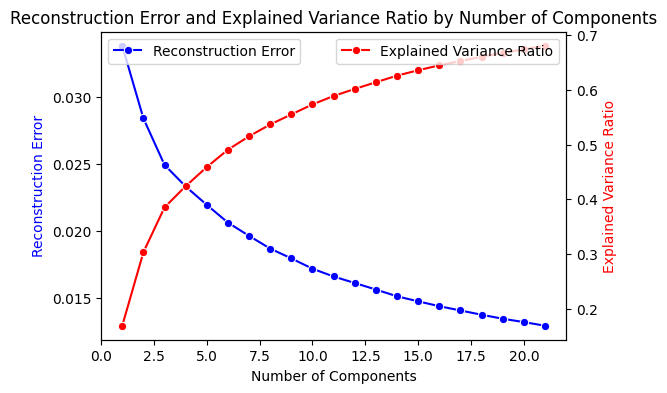

In [ ]:
# Create a DataFrame for plotting
rec_error = pd.DataFrame({
    'n_components': n_components_range,
    'reconst_error': mse_scores,
    'explained_var_ratio': explained_var_ratios
})

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=rec_error, x='n_components', y='reconst_error', ax=ax,
             color='blue', label='Reconstruction Error', marker='o')
ax2 = ax.twinx()
sns.lineplot(data=rec_error, x='n_components', y='explained_var_ratio', ax=ax2,
             color='red', label='Explained Variance Ratio', marker='o')

ax.set_xlabel('Number of Components')
ax.set_ylabel('Reconstruction Error', color='blue')
ax2.set_ylabel('Explained Variance Ratio', color='red')
ax.set_title('Reconstruction Error and Explained Variance Ratio by Number of Components')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

PCA Inverse Transform 20 components

In [ ]:
# PCA Inverse Transform with 20 components
pca = PCA(n_components=20)
X_transformed = pca.fit_transform(cat_centered)
X_inverse = pca.inverse_transform(X_transformed)

Plot by 20 Principal Components

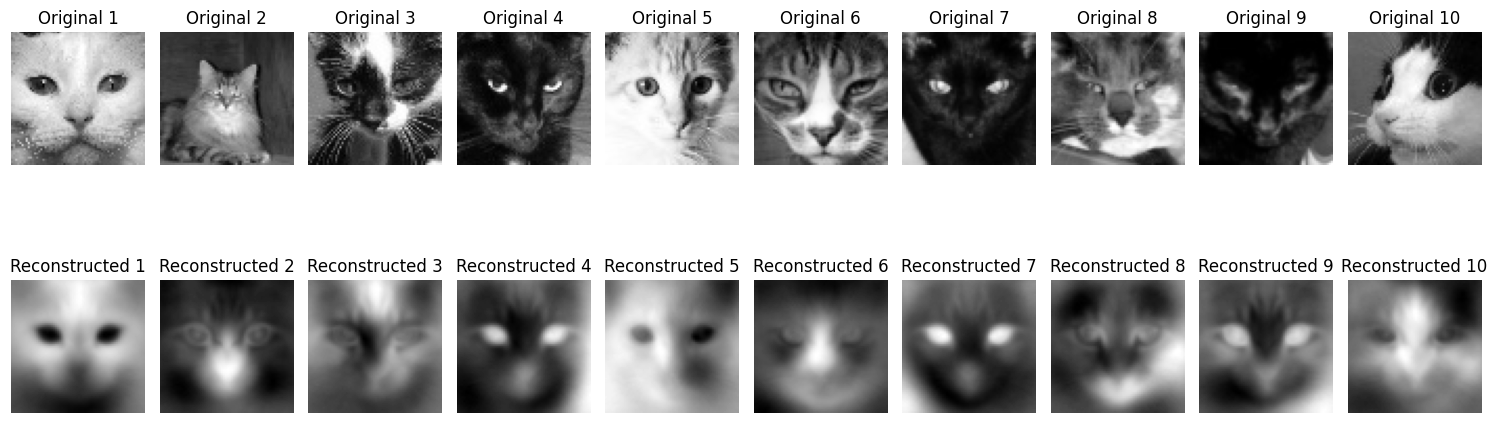

In [ ]:
# Plot original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 6))
for i in range(10):
    axes[0, i].imshow(cat_col_num[i], cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')

    reconstructed = X_inverse[i].reshape(cat_col_num.shape[1],
                                         cat_col_num.shape[2])
    axes[1, i].imshow(reconstructed, cmap='gray')
    axes[1, i].set_title(f'Reconstructed {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

# **2 Clothing Reviews with Unsupervised Learning**

Next, you will revisit our clothing reviews dataset. Load the JSON data from modcloth as you did in assignment module 4.






In [ ]:
#Load the JSON data from modcloth as you did in assignment module 4 here:
df = pd.read_json('/content/modcloth_final_data.json', lines = True)
df.head()

modcloth = pd.DataFrame(df)
# remove rows with null quality values
modcloth = modcloth[modcloth['quality'].notna()]
# remove bust outlier
modcloth = modcloth[modcloth['bust'] != '37-39']

modcloth.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [ ]:
modcloth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82721 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82721 non-null  int64  
 1   waist           2842 non-null   float64
 2   size            82721 non-null  int64  
 3   quality         82721 non-null  float64
 4   cup size        76490 non-null  object 
 5   hips            56030 non-null  float64
 6   bra size        76722 non-null  float64
 7   category        82721 non-null  object 
 8   bust            11832 non-null  object 
 9   height          81618 non-null  object 
 10  user_name       82721 non-null  object 
 11  length          82696 non-null  object 
 12  fit             82721 non-null  object 
 13  user_id         82721 non-null  int64  
 14  shoe size       27885 non-null  float64
 15  shoe width      18587 non-null  object 
 16  review_summary  75999 non-null  object 
 17  review_text     75999 non-null  obje

**Numeric Variables**

In [ ]:
# Define the Functions for Height and Bust Conversion

def conv_height(x):
    if pd.isnull(x):
        return x
    spt = x.split(' ')
    ft = int(spt[0].split('ft')[0])
    inch = 0
    if len(spt) > 1:
        inch = int(spt[1].split('in')[0])
    return (ft * 12) + inch
def conv_bust(x):
    if pd.isnull(x):
        return x
    spt = x.split('-')
    # if range, split the difference
    if len(spt) > 1:
        return (int(spt[1]) - int(spt[0]) // 2) + int(spt[0])
    return int(spt[0])

In [ ]:
# Extract 'quality' Column
labels = modcloth['quality']

# Convert waist, size, hips, bra size, shoe size to numeric:
num_cols = ['waist', 'size', 'hips', 'bra size', 'shoe size', 'quality']

# store to dataframe
num_df = pd.DataFrame()
num_df[num_cols] = modcloth[num_cols].apply(pd.to_numeric, errors='coerce')

# Convert height (inches)
num_df['height'] = modcloth['height'].apply(conv_height)

# Convert bust (inches)
num_df['bust'] = modcloth['bust'].apply(conv_bust)

# See Numerical DF Table
num_df.head()

,waist,size,hips,bra size,shoe size,quality,height,bust
0,29.0,7,38.0,34.0,NaN,5.0,66.0,36.0
1,31.0,13,30.0,36.0,NaN,3.0,62.0,NaN
2,30.0,7,NaN,32.0,9.0,2.0,67.0,NaN
3,NaN,21,NaN,NaN,NaN,5.0,NaN,NaN
4,NaN,18,NaN,36.0,NaN,5.0,62.0,NaN


**Ordinal Encoder**

Use OrdinalEncoder to transform the categorical data to numerical values. Combine the categorical and numerical data into a single data frame.


In [ ]:
# Extract the features and target variable
X = modcloth[['cup size', 'category', 'length', 'fit', 'shoe width']]
y = modcloth['quality']

# Initialize and fit the OrdinalEncoder
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

# Convert to DataFrame
cat_feat = pd.DataFrame(X_encoded, columns=X.columns)
print(cat_feat)

# Print the categories used for encoding
for feature_name, categories in zip(X.columns, encoder.categories_):
    print(f"{feature_name}: {categories}")

       cup size  category  length  fit  shoe width
0           4.0       2.0     0.0  2.0         NaN
1           2.0       2.0     0.0  2.0         NaN
2           2.0       2.0     1.0  2.0         NaN
3           5.0       2.0     0.0  0.0         NaN
4           2.0       2.0     1.0  2.0         NaN
...         ...       ...     ...  ...         ...
82716       2.0       3.0     0.0  0.0         0.0
82717       6.0       3.0     1.0  2.0         NaN
82718       7.0       3.0     0.0  0.0         NaN
82719       NaN       3.0     0.0  0.0         NaN
82720       4.0       3.0     0.0  0.0         NaN

[82721 rows x 5 columns]
cup size: ['a' 'aa' 'b' 'c' 'd' 'dd/e' 'ddd/f' 'dddd/g' 'h' 'i' 'j' 'k' nan]
category: ['bottoms' 'dresses' 'new' 'outerwear' 'sale' 'tops' 'wedding']
length: ['just right' 'slightly long' 'slightly short' 'very long' 'very short'
 nan]
fit: ['fit' 'large' 'small']
shoe width: ['average' 'narrow' 'wide' nan]


Combine Numeric and Categorical


In [ ]:
# Combine categorical and numerical variables
comb_df = pd.merge(cat_feat, num_df[num_df.index.isin(cat_feat.index)],
                   left_index=True, right_index=True)
comb_df.head()

,cup size,category,length,fit,shoe width,waist,size,hips,bra size,shoe size,quality,height,bust
0,4.0,2.0,0.0,2.0,NaN,29.0,7,38.0,34.0,NaN,5.0,66.0,36.0
1,2.0,2.0,0.0,2.0,NaN,31.0,13,30.0,36.0,NaN,3.0,62.0,NaN
2,2.0,2.0,1.0,2.0,NaN,30.0,7,NaN,32.0,9.0,2.0,67.0,NaN
3,5.0,2.0,0.0,0.0,NaN,NaN,21,NaN,NaN,NaN,5.0,NaN,NaN
4,2.0,2.0,1.0,2.0,NaN,NaN,18,NaN,36.0,NaN,5.0,62.0,NaN


In [ ]:
# Prepare variables
X = comb_df.drop('quality', axis=1)
comb_df['quality'] = comb_df['quality'].astype('int64')
labels = comb_df['quality']

In [ ]:
X

,cup size,category,length,fit,shoe width,waist,size,hips,bra size,shoe size,height,bust
0,4.0,2.0,0.0,2.0,NaN,29.0,7,38.0,34.0,NaN,66.0,36.0
1,2.0,2.0,0.0,2.0,NaN,31.0,13,30.0,36.0,NaN,62.0,NaN
2,2.0,2.0,1.0,2.0,NaN,30.0,7,NaN,32.0,9.0,67.0,NaN
3,5.0,2.0,0.0,0.0,NaN,NaN,21,NaN,NaN,NaN,NaN,NaN
4,2.0,2.0,1.0,2.0,NaN,NaN,18,NaN,36.0,NaN,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
82716,2.0,3.0,0.0,0.0,0.0,NaN,4,37.0,36.0,NaN,63.0,34.0
82717,6.0,3.0,1.0,2.0,NaN,NaN,32,50.0,44.0,NaN,64.0,NaN
82718,7.0,3.0,0.0,0.0,NaN,NaN,26,52.0,40.0,NaN,65.0,NaN
82719,NaN,3.0,0.0,0.0,NaN,NaN,1,NaN,34.0,6.0,60.0,NaN


**Statsmodels PCA**

Unfortunately, there is a lot of missing data, which prevents us from directly performing PCA on these data. Instead, you can use the statsmodels package, which has an implementation of PCA that can handle missing data.
Install the statsmodels package here: https://www.statsmodels.org/stable/install.html, and use their PCA function:



```
pc = PCA(X, ncomp=2, method='nipals' ,missing='fill-em')
```

Use seaborn’s scatterplot to plot the first two principal components. Check the statsmodels documentation for information on how to access the principal components from the pc object.

You can use scatterplot with hue=labels to color code the plot by label, as below:

In [ ]:
from statsmodels.multivariate.pca import PCA

# Perform PCA
pc = PCA(X, ncomp=2, method='nipals', missing='fill-em')
principal_components = pc.factors
pca_df = pd.DataFrame(principal_components)
pca_df['label'] = labels.values

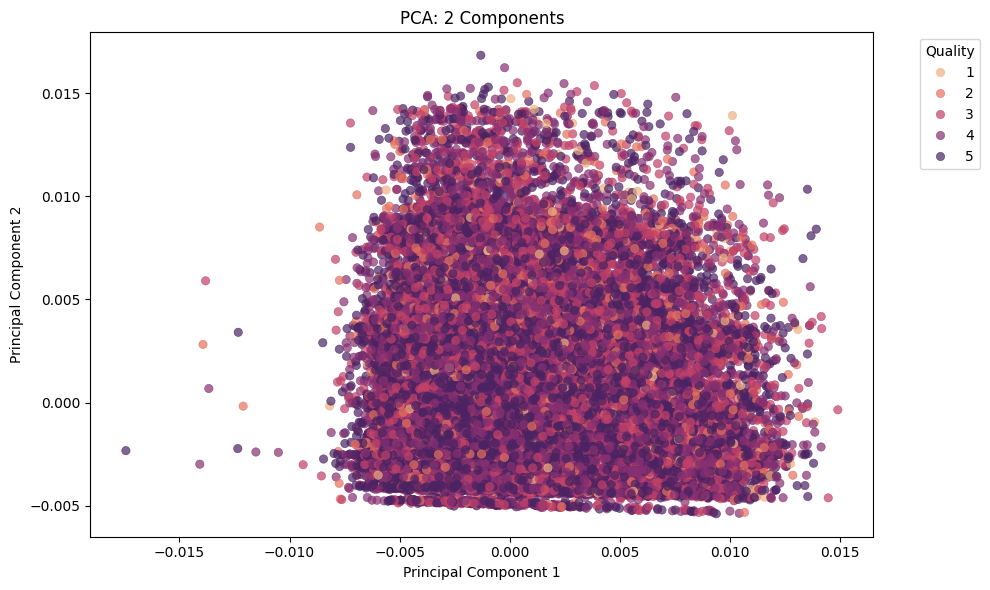

In [ ]:
# Plot the principal components
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=pca_df, x='comp_0', y='comp_1', hue='label',
                          palette='flare', alpha=0.7, edgecolor=None)
plt.title('PCA: 2 Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Repeat the above exercise, but now include labels in the features you use to fit the PCA. This time,
you can observe label information in the resulting plot.


PCA including label information

In [ ]:
from statsmodels.multivariate.pca import PCA

# Perform PCA
pc2 = PCA(comb_df, ncomp=2, method='nipals', missing='fill-em')
principal_components2 = pc2.factors
pca_df2 = pd.DataFrame(principal_components2)
pca_df2['label'] = labels.values

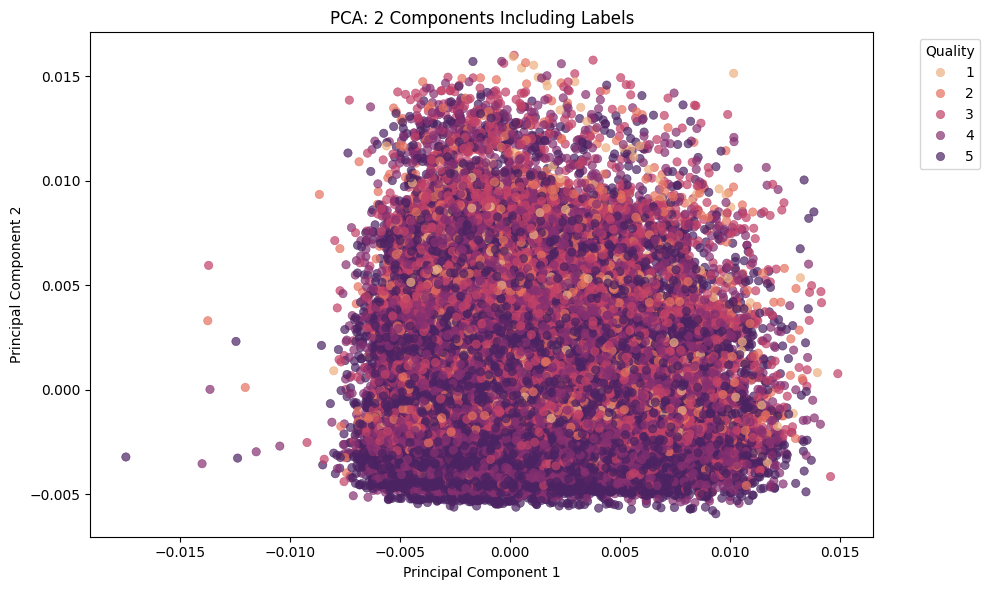

In [ ]:
# Plot the principal components
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=pca_df2, x='comp_0', y='comp_1', hue='label',
                          palette='flare', alpha=0.7, edgecolor=None)
plt.title('PCA: 2 Components Including Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Unsupervised Learning on Clothing Reviews

Next, you will look for structure in the text data.

Adapt the code in the Latent Dirichlet Allocation example in scikit-
learn to work with the text of the clothing reviews: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py. You should have code from assignment module 4 to extract the bag of words features you will need, which you can then pass
to the LDA object.
Modify the code in this example to fit a model with 10 components (topics) to the reviews. Use
the plotting function to visualize the top words in each topic.

In [ ]:
# Extract the 'review_text' column
corpus = modcloth['review_text']

# Remove outliers: Drop records with no text data (NaNs)
corpus = corpus.dropna()
corpus.describe()

count        75999
unique       73247
top       Love it!
freq           153
Name: review_text, dtype: object

CountVectorizer

In [ ]:
# Drop NaNs from the label column and align with corpus index
labels = modcloth['quality'].dropna()
labels = labels.loc[corpus.index]

# Initialize the TfidfVectorizer with a maximum of 1000 features
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
spmat = vectorizer.fit_transform(corpus)

feat_names = vectorizer.get_feature_names_out()

X_review = pd.DataFrame.sparse.from_spmatrix(spmat, columns=feat_names)
labels = labels[corpus.index]

In [ ]:
# Review the following link and define "plot_top_words":
#https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [ ]:
# Define "plot_top_words"
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

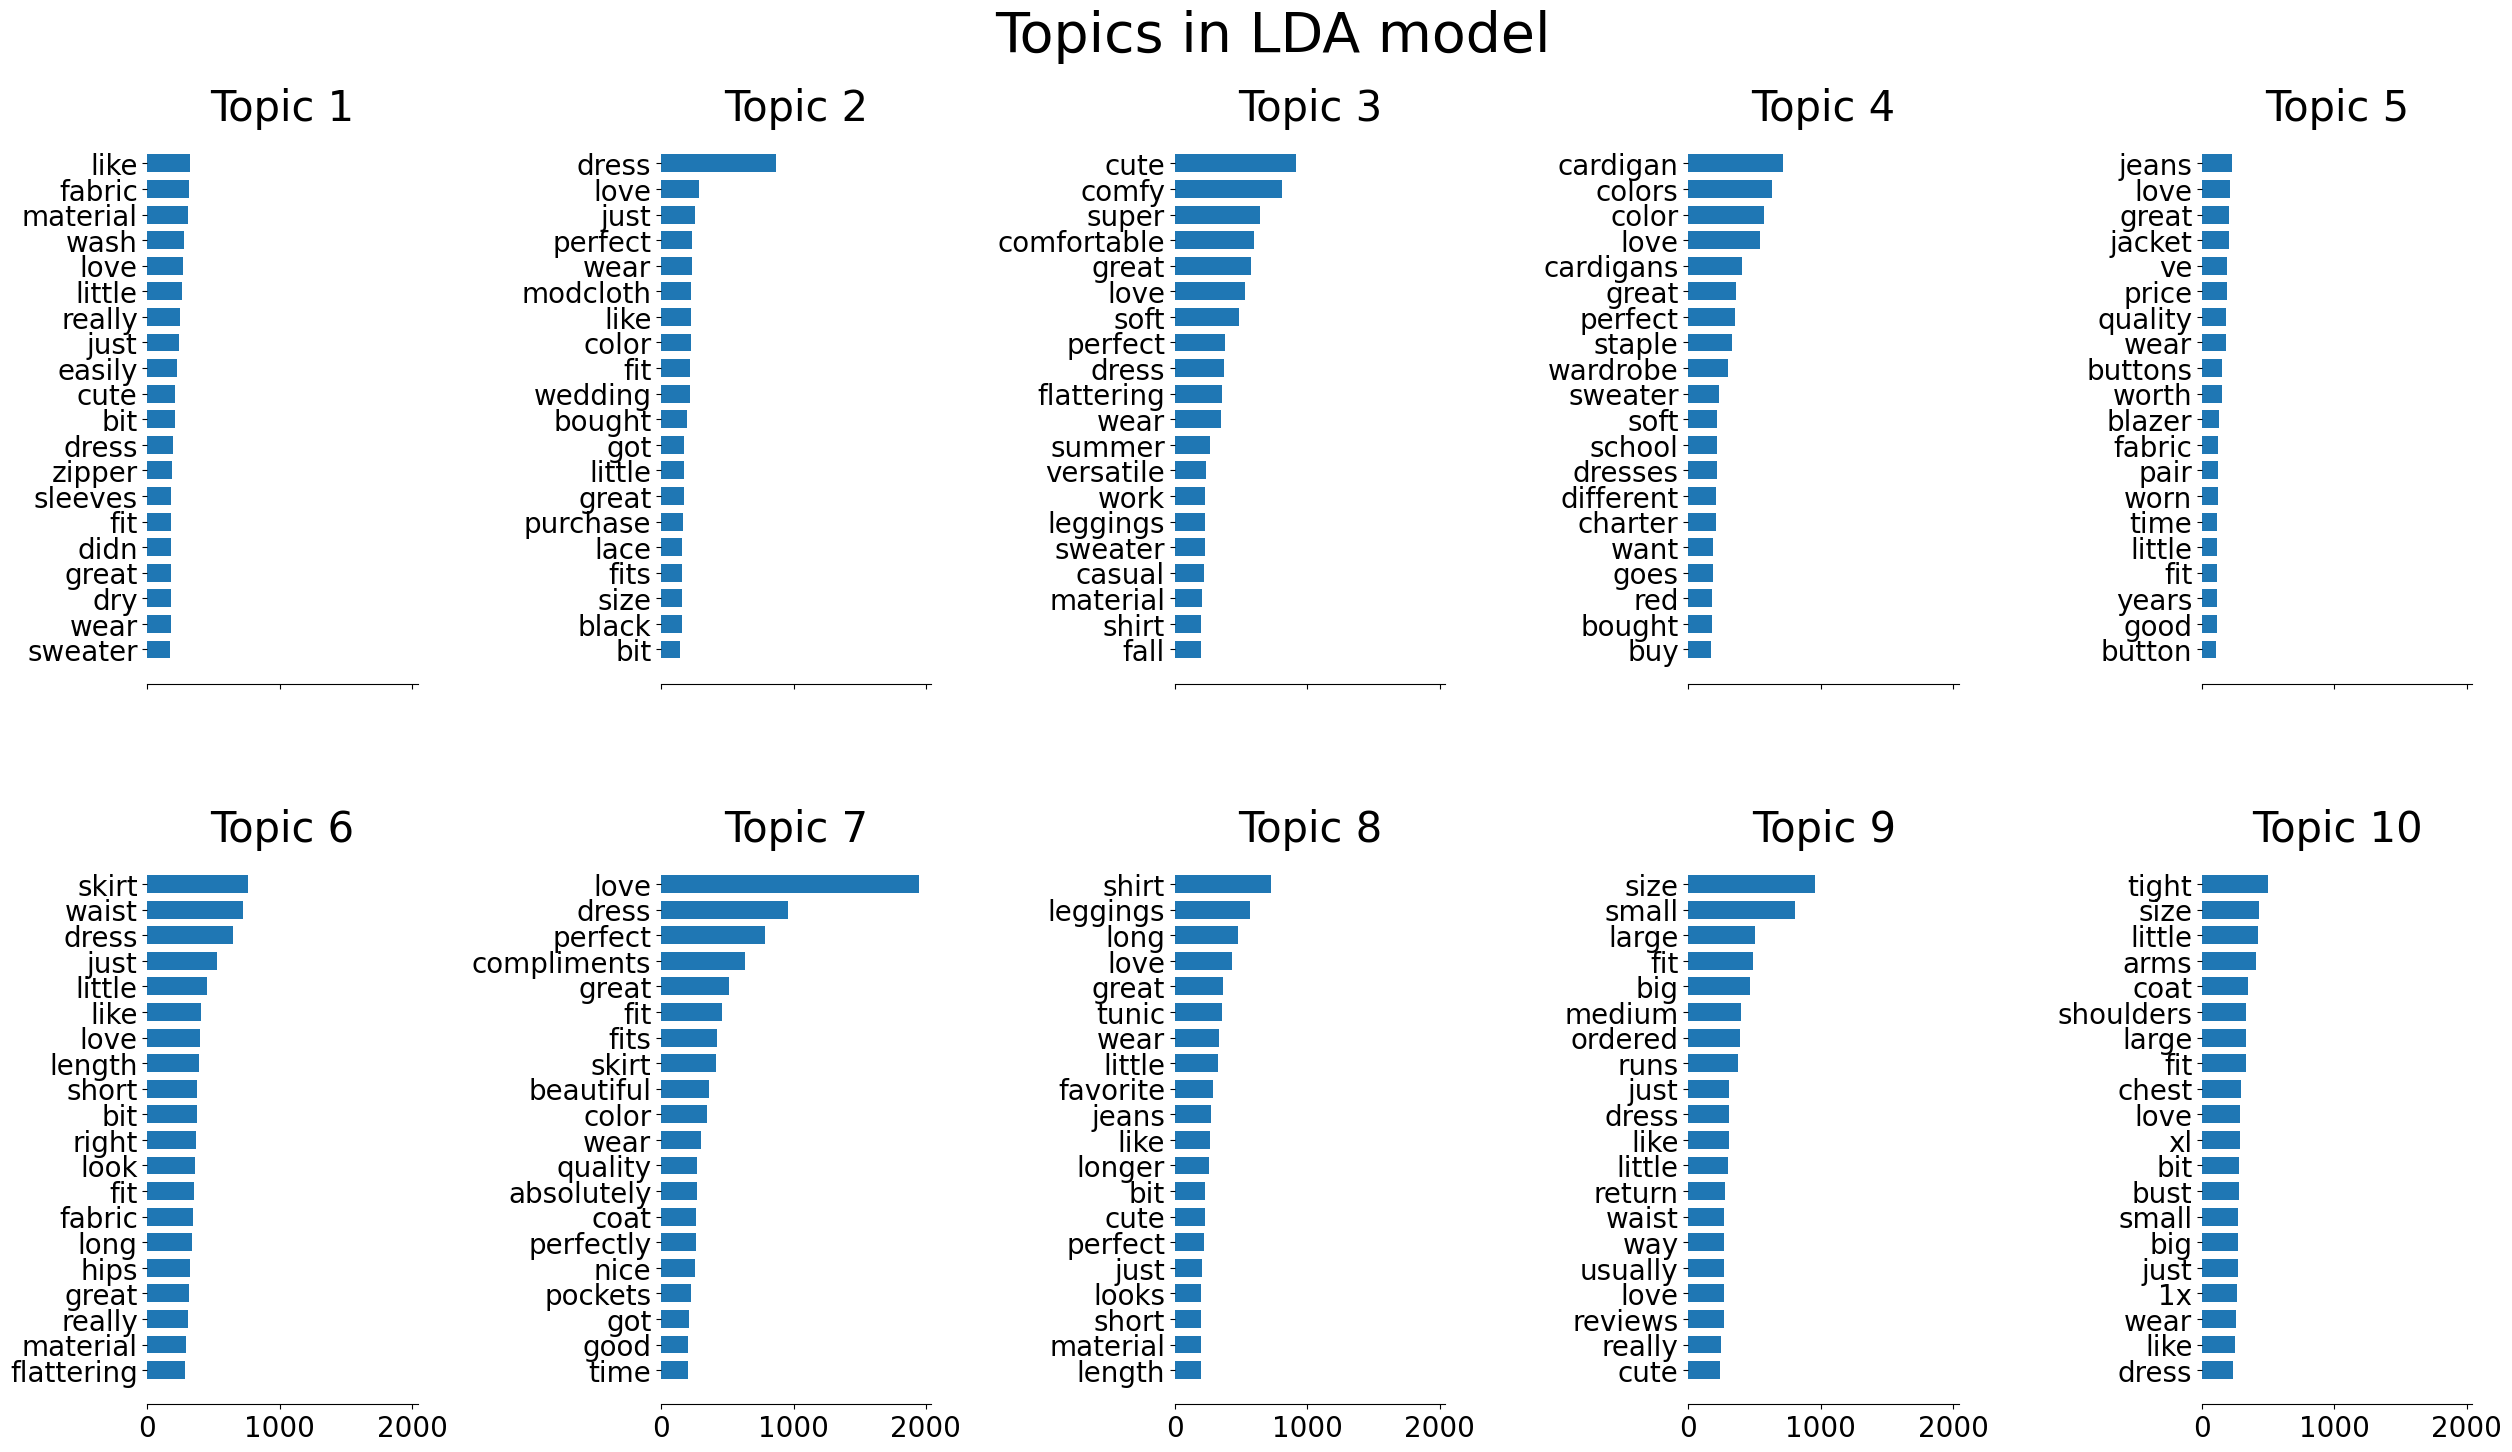

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Initialize the LDA model
n_topics = 10
lda = LDA(n_components=n_topics, random_state=1).fit(X_review)

# Plot the top words
plot_top_words(lda, feat_names, 20, 'Topics in LDA model')

# t-SNE and Manifold Learning
Remove the data points with missing data by using:

`no_missing_data = X.dropna()`

You should have 623 remaining data points. Use t-SNE (https://scikit-learn.org/stable/modules/manifold.html#t-sne) to embed the data points in a low dimensional space. Look at the guide at https://distill.pub/2016/misread-tsne/ and vary the parameters, including the perplexity. When you have an embedding that looks good, label it using the columns of X, using seaborn’s scatterplot and hue. For example, the embedding below shows an apparent variation by size. Plot all the categorical and numerical variables.

In [ ]:
pno_missing_data = X.dropna()
no_missing_data

,cup size,category,length,fit,shoe width,waist,size,hips,bra size,shoe size,height,bust
1069,3.0,2.0,2.0,0.0,0.0,30.0,8,40.0,36.0,8.5,67.0,36.0
1750,7.0,2.0,0.0,0.0,2.0,27.0,8,34.0,34.0,8.0,59.0,38.0
1751,6.0,2.0,0.0,0.0,2.0,33.0,12,36.0,38.0,7.5,63.0,38.0
2367,0.0,2.0,0.0,2.0,0.0,31.0,8,41.0,34.0,8.5,66.0,36.0
2511,3.0,2.0,0.0,0.0,2.0,37.0,15,46.0,36.0,7.0,67.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76973,6.0,0.0,0.0,1.0,0.0,28.0,8,39.0,34.0,6.5,66.0,35.0
77919,3.0,2.0,0.0,0.0,2.0,45.0,20,44.0,38.0,9.5,67.0,45.0
78989,3.0,3.0,0.0,0.0,0.0,32.0,12,42.0,34.0,9.5,69.0,38.0
78990,3.0,3.0,0.0,0.0,0.0,23.0,4,36.0,28.0,5.0,64.0,36.0


In [ ]:
# Extract features from the DataFrame
features = no_missing_data.values

# Configure and fit t-SNE
tsne = TSNE(n_components=2, perplexity=40, n_iter=5000, learning_rate=10,
            n_jobs=2, random_state=42)
tsne_embd = tsne.fit_transform(features)

tsne_df = pd.DataFrame(tsne_embd, columns=['Component 1', 'Component 2'])

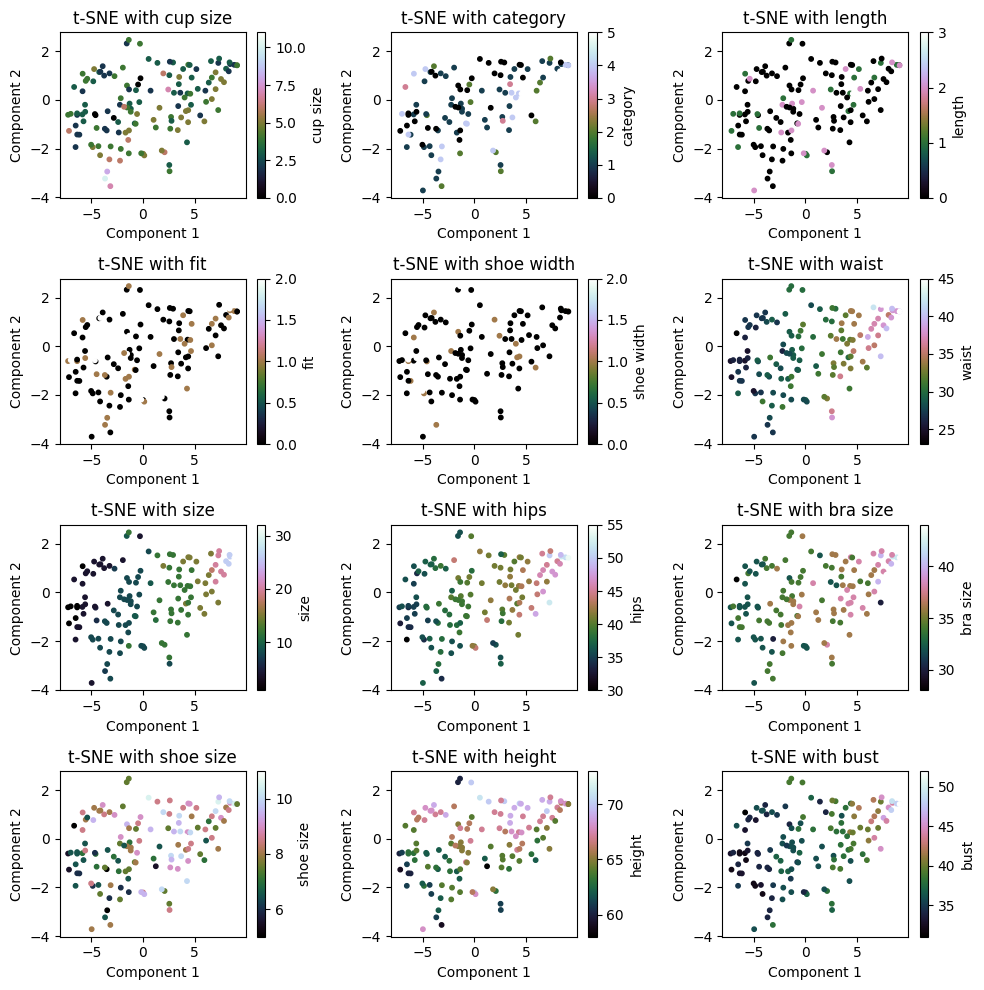

In [ ]:
# Ensure indices match
no_missing_data = no_missing_data.reset_index(drop=True)
tsne_df = tsne_df.reset_index(drop=True)

num_features = no_missing_data.select_dtypes(include=[np.number]).columns

# Plot features with a color bar
fig, axes = plt.subplots(nrows=int(np.ceil(len(num_features) / 3)), ncols=3,
                         figsize=(10, 2.5 * np.ceil(len(num_features) / 3)))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    tsne_df['Feature'] = no_missing_data[feature].values
    scatter = axes[i].scatter(tsne_df['Component 1'], tsne_df['Component 2'],
                              c=tsne_df['Feature'], cmap='cubehelix', s=10)
    axes[i].set_title(f't-SNE with {feature}')
    axes[i].set_xlabel('Component 1')
    axes[i].set_ylabel('Component 2')
    fig.colorbar(scatter, ax=axes[i], label=feature)

for j in range(len(num_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()